<h4> Imports </h4>

In [38]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM

from sklearn.model_selection import train_test_split
from sklearn import ensemble
from sklearn.metrics import mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

<h5> 0. Data import </h5>

In [ ]:
def get_data(start_date, end_date, ticker, df):
    idx = pd.IndexSlice
    new_df = df.loc[idx[start_date:end_date, ticker], :]
    return new_df

df = (pd.read_csv('data/wiki_stocks.csv',
                 parse_dates=['date'],
                 index_col=['date', 'ticker'],
                 infer_datetime_format=True)
     .sort_index())


<h4> 1. Time series naive </h4>
Wrapper function for all models using naive time series data (predicting price)

<h5> 1.1 ARIMA </h5>

In [5]:
%matplotlib inline

from tqdm import tqdm
from itertools import product
import pandas as pd
import pandas_datareader.data as web
import numpy as np
from numpy.linalg import LinAlgError

import statsmodels.tsa.api as tsa
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, q_stat, adfuller
from scipy.stats import probplot, moment

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from statsmodels.tsa.arima.model import ARIMA

# Make a function to find the MSE of a single ARIMA model 
def evaluate_arima_model(data, arima_order):
    # Needs to be an integer because it is later used as an index.
    split=int(len(data) * 0.8) 
    train, test = data[0:split], data[split:len(data)]
    past=[x for x in train]
    # make predictions
    predictions = list()
    for i in range(len(test)):#timestep-wise comparison between test data and one-step prediction ARIMA model. 
        model = ARIMA(past, order=arima_order)
        model_fit = model.fit()
        future = model_fit.forecast()[0]
        predictions.append(future)
        past.append(test[i])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error
# Make a function to evaluate different ARIMA models with several different p, d, and q values.

def evaluate_models(dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                    print('ARIMA%s MSE=%.10f' % (order,mse))
                except:
                    continue
    return print('Best ARIMA%s MSE=%.10f' % (best_cfg, best_score))

In [ ]:
# Now, we choose a couple of values to try for each parameter.
# p_values = [x for x in range(0, 3)]
# d_values = [x for x in range(0, 3)]
# q_values = [x for x in range(0, 3)]

# import warnings
# warnings.filterwarnings("ignore")
# evaluate_models(arima_log, p_values, d_values, q_values)

In [11]:
def ts_arima(data):
    # Calculate ARIMA w/ TS data and print results / return results
    log_dat = np.log(data.reset_index(level = [1])['open'])

    model = ARIMA(log_dat, order=(0, 2, 1))
    model_fit = model.fit()
    forecast = model_fit.forecast(24)

    print(model_fit.summary())

    preds = model_fit.predict()

    plt.figure(figsize=(15,10))
    plt.plot(preds[1:], color = 'red')
    plt.plot(log_dat[1:])

    return model

<h5> 1.2 RNN </h5>

In [12]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y


In [36]:
def ts_rnn(data):
    # Calculate rnn w/ TS data and print results / return results

    results_path = Path('results', 'univariate_time_series')
    if not results_path.exists():
        results_path.mkdir(parents=True)

    dat = data.reset_index(level = [1])[['open']]

    scaler = MinMaxScaler()
    scaled_data = pd.Series(scaler.fit_transform(dat).squeeze(), index=dat.index)

    window_size = 63

    ### Train-test split ###

    X, y = create_univariate_rnn_data(scaled_data, window_size=window_size)

    split=int(len(scaled_data) * 0.8) 

    ### Train on data up to 2018 ###
    X_train = X[:split].values.reshape(-1, window_size, 1)
    y_train = y[:split]

    ### Test on data from 2019 ###
    X_test = X[split:len(scaled_data)].values.reshape(-1, window_size, 1)
    y_test = y[split:len(scaled_data)]

    n_obs, window_size, n_features = X_train.shape

    rnn = Sequential([
        LSTM(units=10, 
            input_shape=(window_size, n_features), name='LSTM'),
        Dense(1, name='Output')
    ])

    ### Define optimizer for RNN ###

    optimizer = tf.keras.optimizers.legacy.RMSprop(learning_rate=0.001,
                                        rho=0.9,
                                        epsilon=1e-08,
                                        decay=0.0)

    ### Compile RNN w/ previously defined optimizer ###
    rnn.compile(loss='mean_squared_error', 
                optimizer=optimizer)

    ### Save best path of model during training ###
    rnn_path = (results_path / 'rnn.h5').as_posix()

    ### Call best model during training ###
    checkpointer = ModelCheckpoint(filepath=rnn_path,
                                verbose=0,
                                monitor='val_loss',
                                save_best_only=True)

    ### Early stopping to prevent overfitting ###
    early_stopping = EarlyStopping(monitor='val_loss', 
                                patience=20,
                                restore_best_weights=True)

    ### Train model ###
    lstm_training = rnn.fit(X_train,
                            y_train,
                            epochs=150,
                            batch_size=20,
                            shuffle=True,
                            validation_data=(X_test, y_test),
                            callbacks=[early_stopping, checkpointer],
                            verbose=0)

    ### More performance benchmarks ###

    train_rmse_scaled = np.sqrt(rnn.evaluate(X_train, y_train, verbose=0))
    test_rmse_scaled = np.sqrt(rnn.evaluate(X_test, y_test, verbose=0))
    print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

    ### We trained on scaled data, therefore our predictions are in scaled form ###
    train_predict_scaled = rnn.predict(X_train)
    test_predict_scaled = rnn.predict(X_test)

    ### Correlation coefficient between predicted and actual values ###
    train_ic = spearmanr(y_train, train_predict_scaled)[0]
    test_ic = spearmanr(y_test, test_predict_scaled)[0]
    print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

    plt.figure(figsize=(15,10))
    plt.plot(test_predict_scaled[1:], color = 'red')
    plt.plot(y_test.values[1:])

    return rnn

In [37]:
data = get_data('2008-01-01', '2018-01-01', "AAPL", df)

<h5> 1.3 Gradient Boosting </h5>

In [42]:
def ts_gb(data):
    # Calculate XGBoost w/ TS data and print results / return results

    gb_dat = data.reset_index(level = [1])['open']

    gb_df = gb_dat.reset_index()
    gb_df.columns = ['date', 'open']

    gb_df['timestamp'] = (gb_df['date'].astype('int64') // 10**9).astype('int32')
    gb_df = gb_df[['open', 'timestamp']]

    dataset = gb_df.values
    X = dataset[:,1].reshape(-1,1)
    Y = dataset[:,0:1]

    validation_size = 0.15
    seed = 7

    X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

    params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01}
    model = ensemble.GradientBoostingRegressor(**params)
    model.fit(X_train, Y_train)

    model_score = model.score(X_train, Y_train)
    print('R2 sq: ',model_score)
    y_predicted = model.predict(X_validation)
    # The mean squared error
    print("Mean squared error: %.2f"% mean_squared_error(Y_validation, y_predicted))
    # Explained variance score: 1 is perfect prediction
    print('Test Variance score: %.2f' % r2_score(Y_validation, y_predicted))
    
    plt.figure(figsize=(15,10))
    plt.plot(y_predicted[1:], color = 'red')
    plt.plot(Y_validation[1:])

    return 

In [ ]:
def ts_rl(data):
    # Calculate Q learning w/ TS data and print results / return results
    return 

In [ ]:
def ts_knn(data):
    # Calculate knn w/ TS data and print results / return results
    return 

In [ ]:
def ts_nb(data):
    # Calculate naive bayes w/ TS data and print results / return results
    return 

In [ ]:
def ts_vae(data):
    # Calculate VAE w/ TS data and print results / return results
    return 

In [ ]:
def ts_prophet(data):
    # Calculate Prophet for seasonality w/ TS data and print results / return results
    return 

In [ ]:
def ts_ensemble(data):
    # Use ensemble of multiple models, some combination of above (NOT RL)
    #  w/ TS data and print results / return results
    return 

In [15]:
def ts_price(model_selection, ticker, date_start, date_end):
    data = get_data(date_start, date_end, ticker, df)
    if model_selection == "ARIMA":
        ts_arima(data)
        pass
    elif model_selection == "RNN":
        ts_rnn(data)
        pass
    elif model_selection == "GB":
        ts_gb(data)
        pass
    elif model_selection == "RL":
        ts_rl(data)
        pass
    elif model_selection == "KNN":
        ts_knn(data)
        pass
    elif model_selection == "NB":
        ts_nb(data)
        pass
    elif model_selection == "VAE":
        ts_vae(data)
        pass
    elif model_selection == "PROPHET":
        ts_prophet(data)
        pass
    elif model_selection == "ENSEMBLE":
        ts_ensemble(data)
        pass
    else:
        pass

R2 sq:  0.9972223384645568
Mean squared error: 72.58
Test Variance score: 1.00


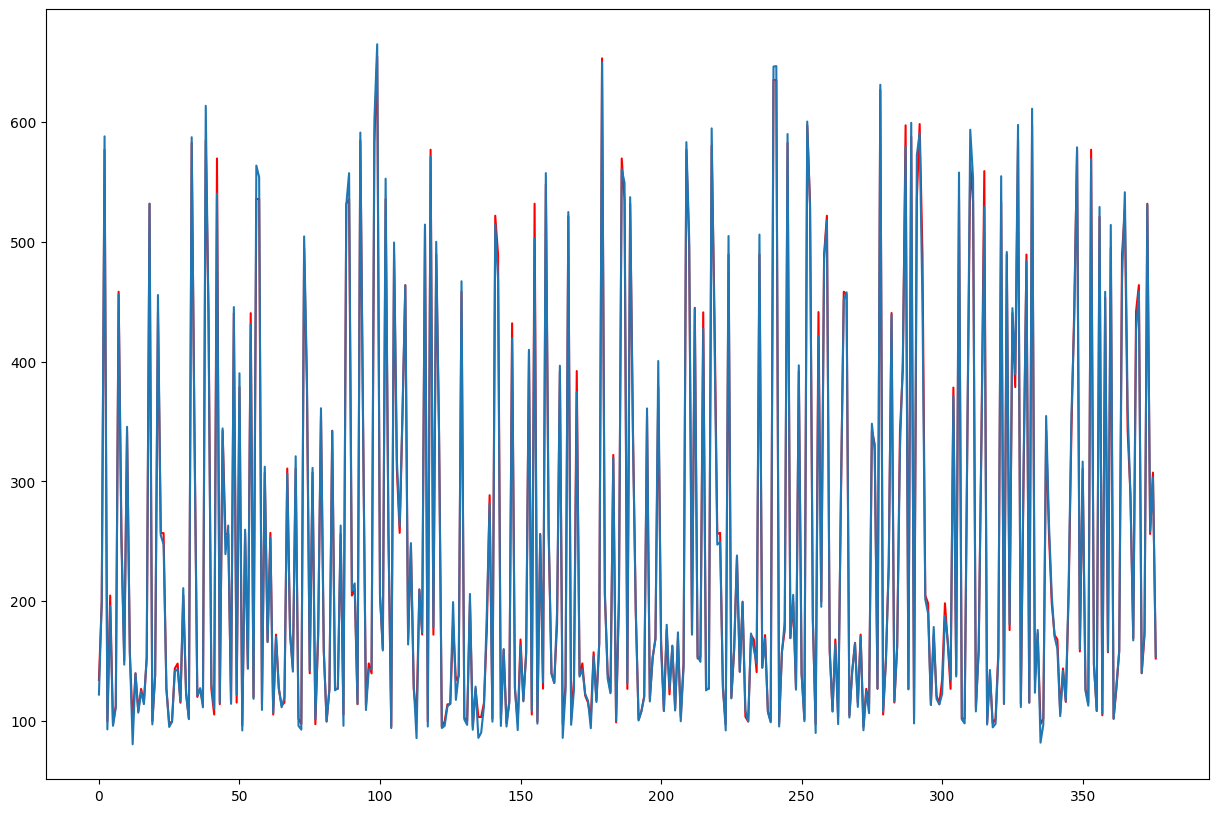

In [45]:
ts_price("GB", "AAPL", '2008-01-01', '2018-01-01')

<h4> 2. Combining other techniques </h4>

<ol>
    <li> Incorporating NLP </li>
    Use twitter data for stocks from previous research
    <li> Use returns for evaluation </li>
    See david's notes
    <li> Predicting indicators such as RSI, Momentum </li>
    See stefan jansen's work
    <li> Non-traditional TS models </li>
    For example, clustering methods? Neural transformers? Classification models? Weighted precision and measure for metric